In [ ]:
# default_exp pnnlDatasets

## Import libraries

This class reads in a dataset and does the necessary preprocessing for a pytorch model.

There are 3 pnnl datasets: 001, 025, 050

The liquid velocity at the top boundary is different for the three cases.
001: 2e-3m/s
025: 6.45e-3m/s
050: 2.18e-2m/s

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# EXPORT
#from torchvision import datasets, transforms
import os, sys
from glob import glob
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import pandas as pd
from scipy.interpolate import interp2d, griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
from surrogates4sims.utils import pkl_load, pkl_save

## PNNL CCSI_2D Dataset Class

In [ ]:
# EXPORT
def plotData(grid_x, grid_y, grid_z, title, pngFile=None):
    plt.figure()
    ax = plt.gca()
    im = ax.pcolormesh(grid_y,grid_x, grid_z, cmap='RdYlBu')
    plt.axes().set_aspect('equal')
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    if pngFile:
        plt.savefig(pngFile, dpi=300)
        plt.close()
        
def interpData(x,y,z,Nx=None,Ny=None,delta_x=None,nextPow2=False,method='linear'):
    '''
    This function takes 3 lists of points (x,y,z) and maps them to a 
    rectangular grid. Either Nx or Ny must be set or delta_x must be set. 
    e.g. 
    
    x = y = z = np.random.rand(30)
    grid_x, grid_y, grid_z = interpData(x,y,z,Nx=128,Ny=128)
    
    or 
    
    grid_x, grid_y, grid_z = interpData(x,y,z,delta_x=1e-3,nextPow2=True)
    '''
    
    eps = 1e-4 # needed to make sure that the interpolation does not have nans. 
    def _NextPowerOfTwo(number):
        # Returns next power of two following 'number'
        return np.ceil(np.log2(number))
    
    if Nx == None and Ny == None:
        assert delta_x != None
        delta_y = delta_x
        Nx = int((x.max() - x.min())/delta_x)
        Ny = int((y.max() - y.min())/delta_y)

    if nextPow2:
        Nx = 2**_NextPowerOfTwo(Nx)
        Ny = 2**_NextPowerOfTwo(Ny)
        
    grid_x, grid_y = np.mgrid[x.min()+eps:x.max()-eps:Nx*1j,y.min()+eps:y.max()-eps:Ny*1j]
    grid_z = griddata(np.array([x,y]).T, z, (grid_x, grid_y), method=method)
    return grid_x, grid_y, grid_z

def plotFrame(fn):
    D = pd.read_csv(fn)
    x = D['X (m)']
    y = D['Y (m)']
    for d in D.columns[:4]:
        z = D[d]
        grid_x, grid_y, grid_z = interpData(x.values,y.values,z.values,delta_x=1e-4)
        idx = getInt(fn)
        d = d.replace(' ','_')
        d = re.sub(r'[^A-Za-z0-9 ]+', '_', d)[:-1]
        title = '{}, Time Step: {}'.format(d,idx)
        pngFile = '{}_{}.png'.format(d,idx)
        plotData(grid_y, grid_x, grid_z, title, pngFile)


class CCSI_2D(Dataset):
    def __init__(self, 
                 dataFiles,
                 txtFile = '/data/ccsi/pnnl_liquid_inlet/liquid_inlet_velocity.txt',
                 channel=1,
                 gridSize=128,
                 simLen = 500,
                 w = 10, # this is the length of the Y output to predict
                 AE = False, # this only return x,x, i.e. no y.
                 numToKeep=np.infty,doPreprocess=False): 
        
        self.dataFiles = dataFiles
        if numToKeep < len(self.dataFiles):
            self.dataFiles = self.dataFiles[:numToKeep]

        self.channel = channel
        self.gridSize = gridSize
        self.numToKeep = numToKeep
        self.simLen = 500
        self.t = np.linspace(0,1,simLen).astype('float32')
        self.w = w
        self.AE = AE
        self.doPreprocess = doPreprocess
        
        # Get the inlet velocity
        with open(txtFile) as fid:
            txt = fid.read().splitlines()
        inletVelocity = np.array(list(map(float,txt[1:]))).astype('float32')
        self.inletMx = np.max(inletVelocity)
        self.inletMn = np.min(inletVelocity)
#         inds = list(map(lambda x: int(x.split('/')[-1].replace('.pkl','')) - 1,self.dataFiles))
#         self.inletVelocity = inletVelocity[inds]
        
        data = []
        for fn in self.dataFiles:
            idx = int(fn.split('/')[-1].replace('.pkl','')) - 1
            D = pkl_load(fn)
            data.append((D,inletVelocity[idx]))
               
        self.data = data
#         if preprocess:
#             for i, d in enumerate(self.data):
#                 self.data[i] = self.preprocessFcn(d)
    
#     def preprocessFcn(self, X,mx=[5.46,4.1,1.,2012.],
#                       mn=[-4.8, -8.8,0.,-1725.]):
#         # mx and mn are the maximums and minimums
#         # of the original data's 4 channels.
#         Xnew = np.empty_like(X)
#         cnt = 0
#         for x,M,m in zip(X,mx,mn):
#             Xnew[cnt] = 2*((x-m)/(M-m) - .5) 
#             cnt += 1
#         return Xnew

#     def inversePreprocessFcn(self, X,mx=[5.46,4.1,1.,2012.],
#                              mn=[-4.8, -8.8,0.,-1725.]):
#         Xnew = np.empty_like(X)
#         cnt = 0
#         for x,M,m in zip(X,mx,mn):
#             Xnew[cnt] = (M - m)*((x/2) + .5) + m 
#             cnt += 1
#         return Xnew
    
    def __len__(self):
        return len(self.simLen*self.data)


#     def plotData(self,idx,pngFile=None):
#         D = self.data[idx]
#         for i in range(4):
#             grid_z = D[i]
#             plt.figure()
#             ax = plt.gca()
#             im = ax.pcolormesh(self.grid_x,self.grid_y, grid_z, cmap='RdYlBu')
#             plt.axes().set_aspect('equal')
#             plt.title('Sample {}, {}'.format(idx,self.column[i]))
#             divider = make_axes_locatable(ax)
#             cax = divider.append_axes("right", size="5%", pad=0.05)
#             plt.colorbar(im, cax=cax)
#             if pngFile:
#                 plt.savefig(pngFile, dpi=300)
#                 plt.close()

    def __getitem__(self, idx):
        if len(self.data) == 1:
            q = 0
            r_idx = idx
        else:
            q,r = np.divmod(idx,self.simLen)
            r_idx = np.random.randint(0,self.simLen-self.w)
            
        X,p = self.data[q]
        x = X[r_idx:r_idx+1]
        #print(x.shape)
        y = X[r_idx+1:r_idx+self.w+1]
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocessFcn(x)
            y = self.preprocessFcn(y)
        
        X = (x.astype('float32'),p,self.t[r_idx])
        Y = (y.astype('float32'),p,self.t[r_idx+1:r_idx+self.w+1])
        if self.AE:
            return X[0],X[0] # this allows LR_finder to work
        else:
            return X,Y


        
class CCSI_2D_old(Dataset):
    def __init__(self, 
                 dataDirec='/data/ccsi/PNNLTimeStepData/001a/',
                 numToKeep=np.infty,transform=None,preprocess=True,
                 Nx=None,Ny=None,delta_x=None,nextPow2=True,interpMethod='linear',
                 channel=None): 
        
        self.data = []
        self.files = []
        self.delta_x = delta_x
        self.nextPow2 = nextPow2
        self.Nx = Nx
        self.Ny = Ny
        self.grid_x = []
        self.grid_y = []
        self.preprocess = preprocess
        self.interpMethod = interpMethod
        self.channel = channel
        
        if type(dataDirec) == list:
            self.files = dataDirec
        elif 'pkl' in dataDirec:
            with open(dataDirec,'rb') as fid:
                D = pickle.load(fid)
                self.data = np.array(D['data'])
                self.grid_x = D['grid_x']
                self.grid_y = D['grid_y']
                if numToKeep < len(self.data):
                     self.data = self.data[:numToKeep]
        else:
            files = glob(os.path.join(dataDirec,'*.csv'))       
            L = np.argsort(list(map(getInt,files)))
            self.files = [files[i] for i in L]
            
        self.dataDirec = dataDirec
        self.numToKeep = numToKeep
        self.transform = transform
        self.preprocess = preprocess
        self.column = []

        
        if self.files is not []:
            if numToKeep < len(self.files):
                self.files = self.files[:numToKeep]

            for f in self.files:
                self.data.append(self.loadfile(f)) 
                
        if preprocess:
            for i, d in enumerate(self.data):
                self.data[i] = self.preprocessFcn(d)

    def loadfile(self,fn):
        D = pd.read_csv(fn)
        x = D['X (m)'].values.astype('float32')
        y = D['Y (m)'].values.astype('float32')
        X = []
        for d in D.columns[:4]:
            z = D[d].values.astype('float32')
            grid_x, grid_y, grid_z = interpData(x,y,z,
                                                self.Nx,self.Ny,
                                                self.delta_x,self.nextPow2,
                                                self.interpMethod)
            X.append(grid_z)
            
        self.grid_x = grid_x
        self.grid_y = grid_y
        self.column = D.columns[:4]
        return np.array(X).astype('float32')

    
    def preprocessFcn(self, X,mx=[5.46,4.1,1.,2012.],
                      mn=[-4.8, -8.8,0.,-1725.]):
        # mx and mn are the maximums and minimums
        # of the original data's 4 channels.
        assert len(X) == 4
        Xnew = np.empty_like(X)
        cnt = 0
        for x,M,m in zip(X,mx,mn):
            Xnew[cnt] = 2*((x-m)/(M-m) - .5) 
            cnt += 1
        return Xnew

    def inversePreprocessFcn(self, X,mx=[5.46,4.1,1.,2012.],
                             mn=[-4.8, -8.8,0.,-1725.]):
        assert len(X) == 4
        Xnew = np.empty_like(X)
        cnt = 0
        for x,M,m in zip(X,mx,mn):
            Xnew[cnt] = (M - m)*((x/2) + .5) + m 
            cnt += 1
        return Xnew
    
    def __len__(self):
        return len(self.data)


    def plotData(self,idx,pngFile=None):
        D = self.data[idx]
        for i in range(4):
            grid_z = D[i]
            plt.figure()
            ax = plt.gca()
            im = ax.pcolormesh(self.grid_x,self.grid_y, grid_z, cmap='RdYlBu')
            plt.axes().set_aspect('equal')
            plt.title('Sample {}, {}'.format(idx,self.column[i]))
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            if pngFile:
                plt.savefig(pngFile, dpi=300)
                plt.close()

    def __getitem__(self, idx):
        X  = self.data[idx].astype('float32')
        if self.channel is not None:
            X = X[self.channel,:,:]
            X = X[np.newaxis]
        
        if self.transform is not None:
            X = self.transform(X)
        return X,X # this allows LR_finder to work


# these functions are in the class too
def preprocessFcn(X,mx=[5.46,4.1,1.,2012.],
                 mn=[-4.8, -8.8,0.,-1725.]):
    # maps the X to [-1,1]
    assert len(X) == 4
    Xnew = np.empty_like(X)
    cnt = 0
    for x,M,m in zip(X,mx,mn):
        Xnew[cnt] = 2*((x-m)/(M-m) - .5) 
        cnt += 1
    return Xnew

def inversePreprocessFcn(X,mx=[5.46,4.1,1.,2012.],
                 mn=[-4.8, -8.8,0.,-1725.]):
    Xnew = np.empty_like(X)
    cnt = 0
    for x,M,m in zip(X,mx,mn):
        Xnew[cnt] = (M - m)*((x/2) + .5) + m 
        cnt += 1
    return Xnew


def getInt(f):
    return int(f.split('_')[-1].replace('.csv',''))

## Testing PNNL Large Dataset

In [ ]:
seed = 1235
np.random.seed(seed=seed)
test_split = .2
channel = 2
gridsize = 128

In [ ]:
raw_data = '/data/ccsi/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
sims = os.listdir(raw_data)
# removeMe = ['041.pkl', '040.pkl', '029.pkl']
# for r in removeMe:
#     sims.remove(r) # fix later
print(sims, len(sims))

['023.pkl', '005.pkl', '016.pkl', '004.pkl', '002.pkl', '021.pkl', '014.pkl', '006.pkl', '009.pkl', '007.pkl', '008.pkl', '010.pkl', '001.pkl', '012.pkl', '003.pkl', '022.pkl', '018.pkl', '013.pkl', '024.pkl', '019.pkl', '011.pkl', '017.pkl', '015.pkl', '020.pkl', '025.pkl', '026.pkl', '027.pkl', '028.pkl', '032.pkl', '029.pkl', '031.pkl', '030.pkl', '036.pkl', '037.pkl', '035.pkl', '039.pkl', '040.pkl', '038.pkl', '044.pkl', '043.pkl', '045.pkl', '042.pkl', '048.pkl', '047.pkl', '049.pkl', '050.pkl', '046.pkl', '033.pkl', '034.pkl', '041.pkl'] 50


In [ ]:
numSims = len(sims)
perm = np.random.permutation(numSims)
idx = int(test_split*numSims)
testInds = perm[:idx]
trainInds = perm[idx:]
testSimFiles = [os.path.join(raw_data,sims[idx]) for idx in testInds]
trainSimFiles = [os.path.join(raw_data,sims[idx]) for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(10, 40)

In [ ]:
txtFile = '/data/ccsi/pnnl_liquid_inlet/liquid_inlet_velocity.txt'
with open(txtFile) as fid:
    txt = fid.read().splitlines()
inletVelocity = np.array(list(map(float,txt[1:])))
inletVelocity, inletVelocity.shape

(array([0.002  , 0.0021 , 0.00221, 0.00232, 0.00243, 0.00255, 0.00268,
        0.00281, 0.00295, 0.0031 , 0.00326, 0.00342, 0.00359, 0.00377,
        0.00396, 0.00416, 0.00437, 0.00458, 0.00481, 0.00505, 0.00531,
        0.00557, 0.00585, 0.00614, 0.00645, 0.00677, 0.00711, 0.00747,
        0.00784, 0.00823, 0.00864, 0.00908, 0.00953, 0.01   , 0.0105 ,
        0.011  , 0.0116 , 0.0122 , 0.0128 , 0.0134 , 0.0141 , 0.0148 ,
        0.0155 , 0.0163 , 0.0171 , 0.018  , 0.0189 , 0.0198 , 0.0208 ,
        0.0218 ]), (50,))

In [ ]:
np.linspace(1,numSims-2,idx).astype('int')

array([ 1,  6, 11, 16, 21, 27, 32, 37, 42, 48])

In [ ]:
testInds, trainInds

(array([36,  9, 27,  8, 37,  6, 23, 43,  4,  1]),
 array([21, 26, 13, 38, 48, 22, 29, 17, 25, 10, 46, 41, 19, 33, 28, 18, 45,
         0, 32, 12,  5, 24, 30, 31, 49, 39, 44, 14, 20, 15, 47, 42, 16, 40,
        35,  7,  3,  2, 34, 11]))

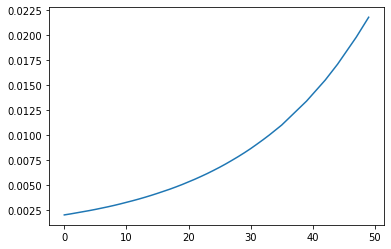

In [ ]:
plt.plot(inletVelocity)

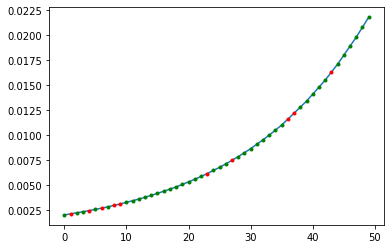

In [ ]:
plt.plot(inletVelocity)
plt.plot(testInds, inletVelocity[testInds], '.r')
plt.plot(trainInds, inletVelocity[trainInds], '.g')

In [ ]:
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
print(testInds,trainInds)

[ 1  6 11 16 21 27 32 37 42 48] [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49]


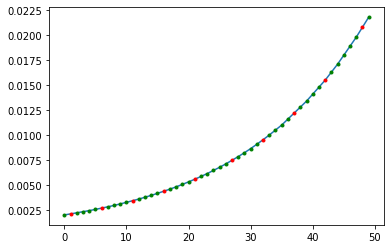

In [ ]:
plt.plot(inletVelocity)
plt.plot(testInds, inletVelocity[testInds], '.r')
plt.plot(trainInds, inletVelocity[trainInds], '.g')

0.0083742 0.005633231076389464


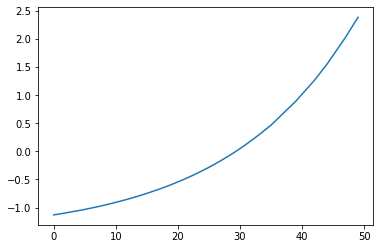

In [ ]:
mu = np.mean(inletVelocity)
sig = np.std(inletVelocity)
print(mu, sig)
normalized_inletVelocity = (inletVelocity - mu)/sig
plt.plot(normalized_inletVelocity)

0.0218 0.002


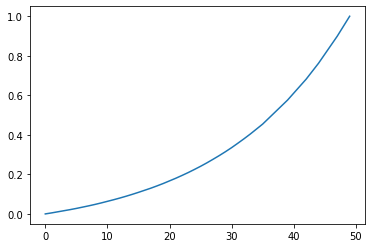

In [ ]:
mx = np.max(inletVelocity)
mn = np.min(inletVelocity)
print(mx,mn)
normalized_inletVelocity = (inletVelocity - mn)/(mx - mn)
plt.plot(normalized_inletVelocity)

In [ ]:
D = CCSI_2D(testSimFiles)
len(D)

4500

In [ ]:
X,Y = D[10]
len(X), len(Y)

(3, 3)

In [ ]:
X[0].shape, X[1], X[2]

((1, 128, 128), 0.00295, 0.9599198)

In [ ]:
Y[0].shape, Y[1], Y[2]

((10, 128, 128),
 0.00295,
 array([0.96192384, 0.96392787, 0.9659319 , 0.96793586, 0.9699399 ,
        0.9719439 , 0.9739479 , 0.9759519 , 0.97795594, 0.9799599 ],
       dtype=float32))

In [ ]:
D = CCSI_2D(testSimFiles,AE=True)
X,Y = D[10]
X.shape, Y.shape

((1, 128, 128), (1, 128, 128))

In [ ]:
D = CCSI_2D([testSimFiles[0]],AE=False)
for idx in range(len(D)):
    X,Y = D[idx]
    print(X[2])

0.0
0.002004008
0.004008016
0.006012024
0.008016032
0.01002004
0.012024048
0.0140280565
0.016032064
0.018036073
0.02004008
0.022044089
0.024048096
0.026052104
0.028056113
0.03006012
0.03206413
0.034068137
0.036072146
0.03807615
0.04008016
0.04208417
0.044088177
0.046092186
0.04809619
0.0501002
0.05210421
0.054108217
0.056112226
0.05811623
0.06012024
0.06212425
0.06412826
0.06613226
0.068136275
0.07014028
0.07214429
0.0741483
0.0761523
0.078156315
0.08016032
0.08216433
0.08416834
0.08617234
0.088176355
0.09018036
0.09218437
0.09418838
0.09619238
0.098196395
0.1002004
0.10220441
0.10420842
0.10621242
0.108216435
0.11022044
0.11222445
0.11422846
0.11623246
0.118236475
0.12024048
0.12224449
0.1242485
0.1262525
0.12825651
0.13026053
0.13226452
0.13426854
0.13627255
0.13827655
0.14028056
0.14228457
0.14428858
0.14629258
0.1482966
0.1503006
0.1523046
0.15430862
0.15631263
0.15831663
0.16032064
0.16232465
0.16432866
0.16633266
0.16833667
0.17034069
0.17234468
0.1743487
0.17635271
0.1783567
0.1

In [ ]:
mx = 0.
mn = np.infty
for s in sims:
    print(s)
    fn = os.path.join(raw_data,s)
    D = pkl_load(fn)
    haveNans = np.any(np.isnan(D))
    if ~haveNans:
        m = D.max()
        n = D.min()
        if m > mx:
            mx = m
            print(mx)
        if n < mn:
            mn = n
            print(mn)
    else:
        print(fn)
print(mn,mx)

023.pkl
1.0
0.0
005.pkl
016.pkl
004.pkl
002.pkl
021.pkl
014.pkl
006.pkl
009.pkl
007.pkl
008.pkl
010.pkl
001.pkl
012.pkl
003.pkl
022.pkl
018.pkl
013.pkl
024.pkl
019.pkl
011.pkl
017.pkl
015.pkl
020.pkl
025.pkl
026.pkl
027.pkl
028.pkl
032.pkl
031.pkl
030.pkl
036.pkl
037.pkl
035.pkl
039.pkl
038.pkl
044.pkl
043.pkl
045.pkl
042.pkl
048.pkl
047.pkl
049.pkl
050.pkl
046.pkl
033.pkl
034.pkl
0.0 1.0


In [ ]:
u = np.unique(D.flatten())
u

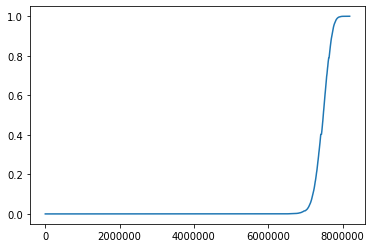

In [ ]:
us = sorted(D.flatten())
plt.plot(us)

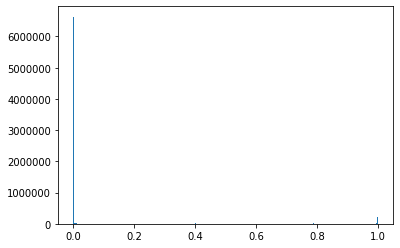

In [ ]:
h = plt.hist(D.flatten(),bins=np.linspace(mn,mx,1000))

In [ ]:
badData = []
for s in sims:
    fn = os.path.join(raw_data,s)
    D = pkl_load(fn)
    haveNans = np.any(np.isnan(D))
    badData.append(s)
    if haveNans:
        print(fn)
        break

/data/ccsi/pnnl_liquid_inlet/channel_1/gridsize_128/029.pkl


In [ ]:
fn = os.path.join(raw_data,'040.pkl')
D = pkl_load(fn)
haveNans = np.any(np.isnan(D))
haveNans

True

In [ ]:
A = np.where(np.isnan(D))
A

(array([360, 360, 360, ..., 360, 360, 360]),
 array([  0,   0,   0, ..., 127, 127, 127]),
 array([  0,   1,   2, ..., 125, 126, 127]))

In [ ]:
frame = A[0]
frame

array([373, 373, 373, ..., 373, 373, 373])

In [ ]:
ordered

## Testing Interpolation Error

In [ ]:
D.max(),D.min()

(nan, nan)

In [ ]:
idx = 0
gridsize = 128
interpolated_data = '/data/ccsi/pnnl_liquid_inlet/channel_1/gridsize_{}'.format(gridsize)

In [ ]:
interpolated_sim_fn = os.path.join(interpolated_data,sims[idx] + '.pkl')
interpolated_sim_fn
interpolated_data = pkl_load(interpolated_sim_fn)
interpolated_data.shape

(500, 128, 128)

In [ ]:
interpolated_grid_fn = '/data/ccsi/pnnl_liquid_inlet/grid_x_grid_y_{}.pkl'.format(gridsize)
gridDict = pkl_load(interpolated_grid_fn)
gridDict.keys()
locals().update(gridDict)

In [ ]:
grid_x.shape, grid_y.shape

((128, 128), (128, 128))

In [ ]:
G = np.array([grid_x.flatten(), grid_y.flatten()])
X = G[0]
Y = G[1]
X.shape, Y.shape

((16384,), (16384,))

In [ ]:
csvFiles = glob(os.path.join(raw_data,sims[idx],'*.csv'))
csvFiles

['/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1000.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_100.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1010.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1020.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1030.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1040.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1050.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1060.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1070.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1080.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1090.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_10.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_1100.csv',
 '/data/ccsi/pn

In [ ]:
L = np.argsort(list(map(getInt,csvFiles)))
orderedFiles = [csvFiles[i] for i in L]
orderedFiles

['/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_10.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_20.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_30.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_40.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_50.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_60.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_70.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_80.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_90.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_100.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_110.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_120.csv',
 '/data/ccsi/pnnl_liquid_inlet/data/001/XYZ_Internal_Table_table_130.csv',
 '/data/ccsi/pnnl_liquid_inlet/dat

In [ ]:
raw_sim = pd.read_csv(orderedFiles[0])
raw_sim.shape, raw_sim.columns

((150073, 7),
 Index(['Velocity[i] (m/s)', 'Velocity[j] (m/s)', 'Volume Fraction of Liq',
        'Pressure (Pa)', 'X (m)', 'Y (m)', 'Z (m)'],
       dtype='object'))

In [ ]:
simX = raw_sim['X (m)']
simY = raw_sim['Y (m)']
vVert = raw_sim['Velocity[j] (m/s)']

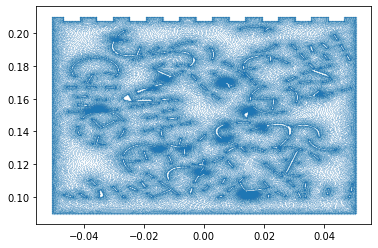

In [ ]:
plt.scatter(simX,simY,s=.01)
plt.show()

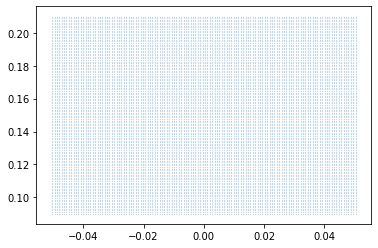

In [ ]:
plt.scatter(G[0],G[1],s=.01)
plt.show()

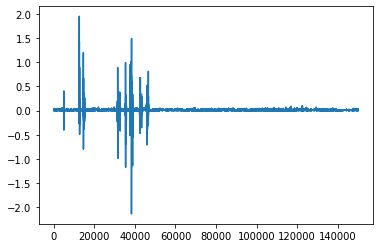

In [ ]:
plt.plot(vVert.values)

In [ ]:
f = interp2d(simX, simY, vVert, kind='linear', bounds_error=False)

In [ ]:
I = f(X,Y)
I.shape

In [ ]:
invf = interp2d(X, Y, I, kind='linear', bounds_error=False)

In [ ]:
vVertApprox = invf(simX,simY)
vVertApprox.shape

### Scipy interpn

In [ ]:
from scipy.interpolate import interpn

In [ ]:
def value_func_3d(x, y, z):
    return 2 * x + 3 * y - z
x = np.linspace(0, 5)
y = np.linspace(0, 5)
z = np.linspace(0, 5)
points = (x, y, z)
values = value_func_3d(*np.meshgrid(*points))
point = np.array([2.21, 3.12, 1.15])
print(interpn(points, values, point))
values.shape, x.shape
#[11.72]

In [ ]:
A = np.meshgrid(*points)
len(A), A[0].shape

In [ ]:
# points = np.array((simX,simY))
# points.shape
points = (simX.values,simY.values)


In [ ]:
G.shape

In [ ]:
simZ.shape

In [ ]:
xx = np.unique(grid_x)
yy = np.unique(grid_y)
xx.shape, yy.shape

In [ ]:
P = np.array([simX,simY])
P = P.T
P.shape

In [ ]:
invInterpolatedData = interpn((xx,yy), interpolated_data[0], P, bounds_error=False, fill_value=3)
invInterpolatedData.shape

In [ ]:
invInterpolatedData, simZ.values

In [ ]:
inds = np.arange(150073)
plt.plot(inds, invInterpolatedData, inds, simZ.values)

In [ ]:
plt.plot(inds, simZ.values)

In [ ]:
interpolatedData = interpn(points, simZ, G, bounds_error=False, fill_value=3)
interpolatedData.shape

In [ ]:
simZ.shape, points.shape

In [ ]:
interpn?

In [ ]:
    bounds_error=True,
    fill_value=nan,

In [ ]:
interp2d?

## Playground test the CCSI_2D class

In [ ]:
# each sim is broken into two directories 'a' and 'b'
dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
sims = ['001','025','050']
simIdx = 0
files = []
for i in ['a','b']:
    pth = os.path.join(dataDirec,sims[simIdx] + i)
    files.append(glob(os.path.join(pth,'*.csv')))
files = [i for sublist in files for i in sublist]
len(files)

In [ ]:
L = np.argsort(list(map(getInt,files)))
L

In [ ]:
orderedFiles = [files[i] for i in L]
orderedFiles

In [ ]:
D = pd.read_csv(orderedFiles[0])
x = D['X (m)']
y = D['Y (m)']
vj = D['Velocity[j] (m/s)']

In [ ]:
plt.scatter(x,y,s=.01)
plt.show()

In [ ]:
Nx = Ny = 128
grid_x, grid_y, grid_z = interpData(x.values,y.values,vj.values,Nx=Nx,Ny=Ny)
grid_x.shape, grid_y.shape, grid_z.shape

In [ ]:
len(x), grid_x.size # the original dataset vs. interpolated

## Re-interpolation error

In [ ]:
points = np.array([grid_x.flatten(), grid_y.flatten()])
print(points.shape)
plt.scatter(points[0],points[1],s=.01)
plt.show()

In [ ]:
f = interp2d(grid_x.flatten(), grid_y.flatten(), grid_z.flatten())

In [ ]:
vj_recon = f(x,y)

In [ ]:
m = 10000
vj_recon = f(x[:m],y[:m])

In [ ]:
vj_recon.shape

In [ ]:
grid_x1, grid_y1 = np.mgrid[0:1:100j, 0:1:200j]
grid_x1.shape, grid_y1.shape

In [ ]:
grid_x, grid_y, grid_z = interpData(x.values,y.values,vj.values,delta_x=1e-3,nextPow2=True)
grid_x.shape, grid_y.shape, grid_z.shape

In [ ]:
len(x), grid_x.size # the original dataset vs. interpolated

In [ ]:
512**2

In [ ]:
112*64*32

In [ ]:
64*96*64

In [ ]:
48*72*48

In [ ]:
plotFrame(orderedFiles[100])

In [ ]:
D = CCSI_2D(orderedFiles,Nx=128,Ny=128,numToKeep=1,interpMethod='cubic')

In [ ]:
np.any(np.isnan(D.data))

In [ ]:
D.plotData(0)

In [ ]:
D = CCSI_2D(orderedFiles,delta_x=1e-4,nextPow2=True,numToKeep=1)

In [ ]:
print(np.any(np.isnan(D.data)))
D.plotData(0)

### Create the 128x128 dataset

In [ ]:
# from surrogates4sims.utils import pkl_save
# outdirec = '/data/ccsi/PNNLTimeStepData/data_128x128_linear'
# if not os.path.exists(outdirec):
#     os.makedirs(outdirec)
    
# dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
# sims = ['001','025','050']
# for s in tqdm(sims):
#     files = []
#     for i in ['a','b']:
#         pth = os.path.join(dataDirec,sims[simIdx] + i)
#         files.append(glob(os.path.join(pth,'*.csv')))
#     files = [i for sublist in files for i in sublist]
#     L = np.argsort(list(map(getInt,files)))
#     orderedFiles = [files[i] for i in L]
#     D = CCSI_2D(orderedFiles,Nx=128,Ny=128)
#     data = {'grid_x':D.grid_x, 'grid_y': D.grid_y, 'data':D.data}
#     s = os.path.join(outdirec,s + '.pkl')
#     pkl_save(data,s)

In [ ]:
## cubic dataset 
# D = CCSI_2D(orderedFiles,Nx=128,Ny=128,interpMethod='cubic') # takes 1.5 hours
# data = {'grid_x':D.grid_x, 'grid_y': D.grid_y, 'data':D.data}
# s = os.path.join('/data/ccsi/PNNLTimeStepData/data_128x128_cubic',sims[simIdx] + '.pkl')
# with open(s,'wb') as fid:
#     pickle.dump(data,fid)

### Create the 512x512 dataset

In [ ]:
# from surrogates4sims.utils import pkl_save
# n = 512
# outdirec = '/data/ccsi/PNNLTimeStepData/data_{}x{}_linear'.format(n,n)
# if not os.path.exists(outdirec):
#     os.makedirs(outdirec)
    
# dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
# sims = ['001','025','050']
# for s in tqdm(sims):
#     files = []
#     for i in ['a','b']:
#         pth = os.path.join(dataDirec,sims[simIdx] + i)
#         files.append(glob(os.path.join(pth,'*.csv')))
#     files = [i for sublist in files for i in sublist]
#     L = np.argsort(list(map(getInt,files)))
#     orderedFiles = [files[i] for i in L]
#     D = CCSI_2D(orderedFiles,Nx=n,Ny=n)
#     data = {'grid_x':D.grid_x, 'grid_y': D.grid_y, 'data':D.data}
#     s = os.path.join(outdirec,s + '.pkl')
#     pkl_save(data,s)

### Read in the saved dataset above

In [ ]:
D = CCSI_2D('/data/ccsi/PNNLTimeStepData/data_128x128_cubic/025.pkl',preprocess=False)
len(D)

In [ ]:
a = D.preprocessFcn(D[0][0])
a.shape

In [ ]:
b = D.inversePreprocessFcn(a)
b.shape

In [ ]:
np.max(np.abs(b-D[0][0]))

### Create the preprocessing function

In [ ]:
dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
sims = ['001','025','050']

files = []
for s in sims:
    for i in ['a','b']:
        pth = os.path.join(dataDirec,s + i)
        files.append(glob(os.path.join(pth,'*.csv')))
files = [i for sublist in files for i in sublist]
len(files)

In [ ]:
x = D.max().values
x.shape

In [ ]:
mx = -100*np.zeros((1,n))
mx.shape

In [ ]:
n = 4
mx = -100*np.zeros((1,n))
mn = 100*np.zeros((1,n))
for f in files:
    D = pd.read_csv(f)
    
    M = D.max().values[:4].reshape(1,n)
    out = np.concatenate([mx,M])
    mx = np.max(out,axis=0).reshape(1,n)
    
    m = D.min().values[:4].reshape(1,n)
    out = np.concatenate([mn,m])
    mn = np.min(out,axis=0).reshape(1,n)

print(mx,mn)

In [ ]:
def preprocess(X,mx=[5.46,4.1,1.,2012.],
                 mn=[-4.8, -8.8,0.,-1725.]):
    Xnew = np.empty_like(X)
    cnt = 0
    for x,M,m in zip(X,mx,mn):
        Xnew[cnt] = 2*((x-m)/(M-m) - .5) 
        cnt += 1
    return Xnew


## Histograms

In [ ]:
D = CCSI_2D('/data/ccsi/PNNLTimeStepData/data_128x128_linear/025.pkl',preprocess=False)
X = D.data
for i in range(X.shape[1]):
    E = X[:,i]
    E = E.flatten()
    mn, mx = E.min(),E.max()
    print(mn,mx)
    bins = np.linspace(mn,mx,1000)
    plt.hist(E,bins)
    plt.show()

In [ ]:
D = CCSI_2D('/data/ccsi/PNNLTimeStepData/data_128x128_linear/025.pkl',preprocess=True)
X = D.data
for i in range(X.shape[1]):
    E = X[:,i]
    E = E.flatten()
    bins = np.linspace(E.min(),E.max(),1000)
    plt.hist(E,bins)
    plt.show()

In [ ]:
E.max()

In [ ]:
E.min()

In [ ]:
E = X[:,2]
E = E.flatten()

In [ ]:
E

In [ ]:
E.max(), E.min(), np.mean(E), np.median(E)

In [ ]:
mu = E.mean()
sig = E.std()
sig

In [ ]:
En = (E - mu)/sig

In [ ]:
bins = np.linspace(E.min(),E.max(),1000)
plt.hist(En,bins)
plt.show()

In [ ]:
bins = np.linspace(E.min(),-.99,1000)
plt.hist(E,bins)
plt.show()

In [ ]:
En.min(),mu + 1*sig

In [ ]:
En

In [ ]:
plt.plot(sorted(E),'.')

In [ ]:
np.sum(E==-1.)/len(E)

In [ ]:
np.sum(E==1.)/len(E)

In [ ]:
np.sum(E > -1.)/len(E)

In [ ]:
A = X[:,2]
for a in A[400:]:
    plt.imshow(a.T)
    plt.show()